# Inter-Maimi - PROD Retention Score
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

In [2]:
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pycaret.classification import *

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [3]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [4]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [mlsInterMiami].[ds].[getRetentionScoringModelData] 113 """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(6938, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  6938 non-null   int64  
 1   year                 6938 non-null   int64  
 2   productGrouping      6938 non-null   object 
 3   email                6921 non-null   object 
 4   ticketingid          6938 non-null   object 
 5   totalSpent           6938 non-null   float64
 6   recentDate           6938 non-null   object 
 7   attendancePercent    6938 non-null   float64
 8   renewedBeforeDays    6938 non-null   int64  
 9   source_tenure        6938 non-null   int64  
 10  tenure               6938 non-null   int64  
 11  distToVenue          6729 non-null   float64
 12  recency              6938 non-null   int64  
 13  missed_games_1       6938 non-null   int64  
 14  missed_games_2       6938 non-null   int64  
 15  missed_games_over_2  6938 non-null   i

### We should specify the features used in our model:

In [6]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "email",
            "ticketingid",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3599, 17)
Unseen Data For Predictions: (635, 17)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [7]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","email","productGrouping","ticketingid","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [8]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6306,0.6981,0.6913,0.6162,0.6512,0.2612,0.2637,0.6710


In [9]:
lightgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5752,0.6474,0.6013,0.5714,0.5860,0.1503,0.1505
1,0.6438,0.7227,0.7059,0.6279,0.6646,0.2876,0.2898
2,0.6438,0.7064,0.6667,0.6375,0.6518,0.2876,0.2879
3,0.6144,0.6763,0.7320,0.5926,0.6550,0.2288,0.2354
4,0.6438,0.6965,0.7124,0.6264,0.6667,0.2876,0.2903
5,0.6569,0.7215,0.7516,0.6319,0.6866,0.3137,0.3195
6,0.6569,0.7014,0.7386,0.6348,0.6828,0.3137,0.3180
7,0.6569,0.7499,0.6993,0.6446,0.6708,0.3137,0.3149
8,0.6013,0.6541,0.6340,0.5951,0.6139,0.2026,0.2030
9,0.6131,0.7047,0.6711,0.6000,0.6335,0.2265,0.2281


### Let's load in our 2021 season data and get retention scores using the model:

In [10]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(2704, 17)

In [11]:
lightgbm_predictions = predict_model(lightgbm_model, data=df_inference, raw_score=True)

In [12]:
print(f"lightgbm:\n {lightgbm_predictions.Label.value_counts()}")

lightgbm:
 0    2033
1     671
Name: Label, dtype: int64


In [13]:
print(f"lightgbm:\n {lightgbm_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")

lightgbm:
 (0.25, 0.5]       1041
(-0.001, 0.25]     992
(0.5, 0.75]        548
(0.75, 1.0]        123
Name: Score_1, dtype: int64


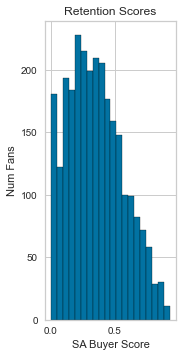

In [14]:
model_predictions = [lightgbm_predictions]

for idx, df_predictions in enumerate(model_predictions):

    plt.subplot(1, 3, idx+1)

    plt.hist(df_predictions["Score_1"], bins=20, edgecolor='black')
    plt.title("Retention Scores")
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

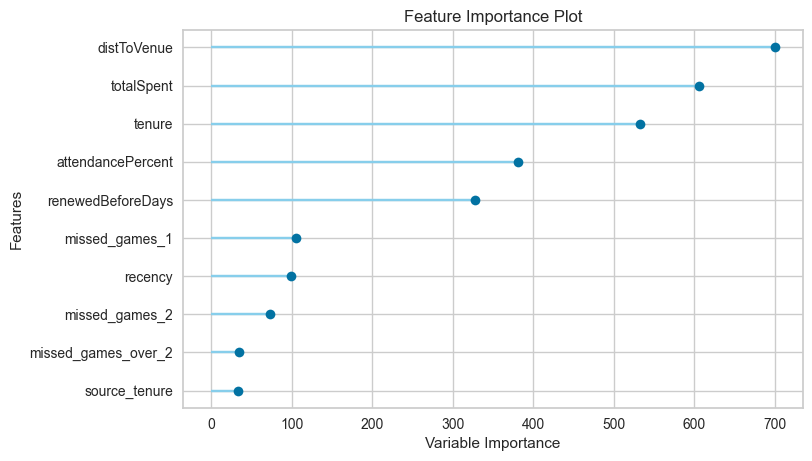

In [15]:
plot_model(lightgbm_model, plot='feature')

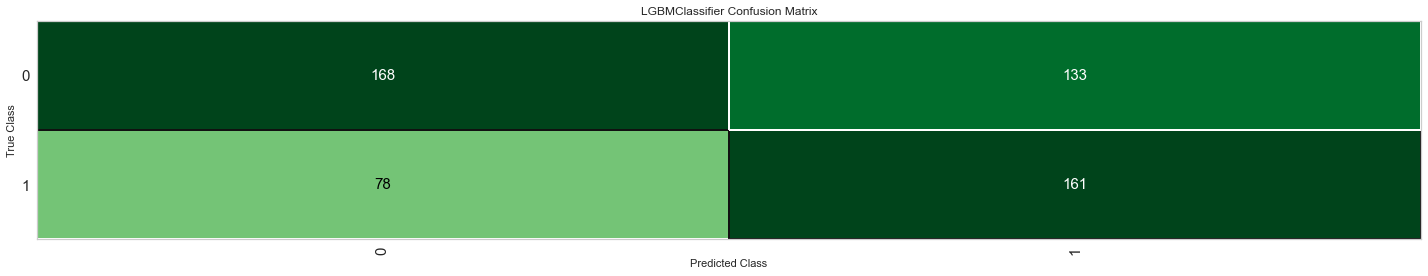

In [16]:
plot_model(lightgbm_model, plot='confusion_matrix')

In [17]:
lightgbm_predictions

,dimCustomerMasterId,year,productGrouping,email,ticketingid,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
2,52,2022,Full Season,06guer1103@gmail.com,253859,1926.10,2022-08-20,0.96,96,730,746,3763.40,0,1,0,0,0,0,0.6717,0.3283
5,179,2022,Flex Plan,195cleanup@gmail.com,270764,312.00,2022-07-13,0.88,10,730,150,38.20,0,0,0,0,0,0,0.9557,0.0443
9,466,2022,Full Season,4jcmas@gmail.com,232105,12257.00,2022-08-20,0.60,162,730,949,48.37,0,1,0,1,0,1,0.3490,0.6510
12,530,2022,Full Season,6xiirt@gmail.com,277117,875.50,2022-08-20,0.62,159,730,950,57.52,0,2,2,0,0,0,0.7739,0.2261
15,632,2022,Full Season,9espi9@gmail.com,295807,439.84,1970-01-01,0.00,162,730,752,47.79,0,0,0,1,0,0,0.9106,0.0894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,149652,2022,Full Season,zkholt@gmail.com,128632,24800.00,2022-08-20,0.56,157,1095,1101,8.55,2,0,2,0,0,1,0.3021,0.6979
6913,149670,2022,Full Season,zmahmood01@gmail.com,923771,4488.00,2022-08-20,0.92,82,365,307,26.68,0,2,0,0,0,0,0.8111,0.1889
6916,149774,2022,Full Season,zs@dzdgroup.com,186312,12257.00,2022-08-20,0.65,162,1095,1098,27.58,0,3,0,0,0,0,0.5352,0.4648
6919,149844,2022,Full Season,zunigajulian@hotmail.com,127107,1575.90,2022-08-13,0.27,162,1095,948,47.74,0,1,1,2,0,0,0.7520,0.2480


In [18]:
current_date = datetime.today().strftime('%Y-%m-%d')
#lightgbm_predictions.to_json(f"Results/InterMiami_Retention_Scores_{current_date}.csv.out", orient="records")
lightgbm_predictions.to_csv(f"Results/InterMiami_Retention_Scores_{current_date}.csv", index=False)